>>[Initial Step](#scrollTo=QnRf6wKUlOfk)

>>[Exploratory Data Analysis(EDA)](#scrollTo=cGxiPmDlgj4u)

>>>[Datasets](#scrollTo=SjE8OwQ3k6rT)

>>>[Check if there are NULL values](#scrollTo=2oNxW4g6kY_b)

>>>[Dimensions of Datasets](#scrollTo=4B9dCwqtk-zz)

>>>[Distribution of Datasets](#scrollTo=C9aL0IlGlEGk)

>>[Data Preprocessing](#scrollTo=4Pbt7IrmmKFE)

>>>[Convert positive to 1, and negative to 0](#scrollTo=IcnTBruJzZWp)

>>>[Initial Values](#scrollTo=rsokV40P7Xz5)

>>>[Custom Dataset](#scrollTo=c_8VUTOW7bA2)

>>>[Prepare Datasets for Processing](#scrollTo=cS7BfJ8KoI2r)

>>[Implement BERT Transformer](#scrollTo=O98wYnPepZv5)

>>>[Train The Model](#scrollTo=DSChRMGAs4mM)

>>[Validate The Performance Of The Model](#scrollTo=TUW5gOZfq8Kq)



## Initial Step

In [1]:
!pip install -q transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn import metrics
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda
from sklearn.model_selection import train_test_split

In [3]:
device = 'cuda' if cuda.is_available else 'cpu'
device

'cuda'

In [4]:
train_set = pd.read_json('/content/drive/MyDrive/NLP Challenge/SST2_Train.json')
test_set = pd.read_json('/content/drive/MyDrive/NLP Challenge/SST2_Test.json')

In [5]:
max = 0
for i in range(len(train_set.text)):
  if len(str(train_set.text[i])) >= max:
    max = len(str(train_set.text[i]))

max

294

## Exploratory Data Analysis(EDA)

**In this section, we are going to explore the dataset and extract useful intuitions.**

### Datasets

In [6]:
train_set

,text,label
0,"a stirring , funny and finally transporting re...",positive
1,apparently reassembled from the cutting - room...,negative
2,they presume their audience wo n ' t sit still...,negative
3,this is a visually stunning rumination on love...,positive
4,jonathan parker ' s bartleby should have been ...,positive
...,...,...
7442,jose campanella delivers a loosely autobiograp...,positive
7443,". . . mafia , rap stars and hood rats butt the...",positive
7444,i got a headache watching this meaningless dow...,negative
7445,montias . . . pumps a lot of energy into his n...,positive


In [7]:
test_set

,text,label
0,"no movement , no yuks , not much of anything",negative
1,"a gob of drivel so sickly sweet , even the eag...",negative
2,"gangs of new york is an unapologetic mess , wh...",negative
3,"we never really feel involved with the story ,...",negative
4,this is one of polanski ' s best films,positive
...,...,...
1816,"an often deadly boring , strange reading of a ...",negative
1817,the problem with concept films is that if the ...,negative
1818,"safe conduct , however ambitious and well inte...",negative
1819,"a film made with as little wit , interest , an...",negative


### Check if there are NULL values

In [8]:
test_set[test_set['label']== None]

,text,label


In [9]:
train_set[train_set['label']== None]

,text,label


### Dimensions of Datasets

In [10]:
print(f'TRAIN SET shape is: {train_set.shape}, and TEST SET shape is: {test_set.shape}')

TRAIN SET shape is: (7447, 2), and TEST SET shape is: (1821, 2)


### Distribution of Datasets

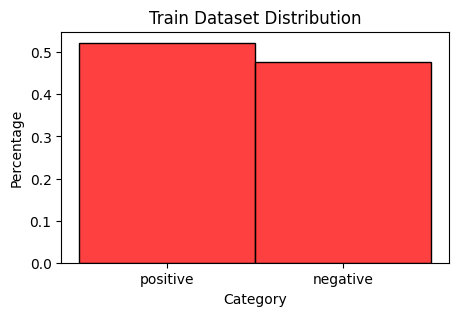

In [11]:
fig, ax = plt.subplots(figsize = (5, 3))
plt.title('Train Dataset Distribution')
sns.histplot(train_set.label, color='red', discrete=True, stat='probability')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

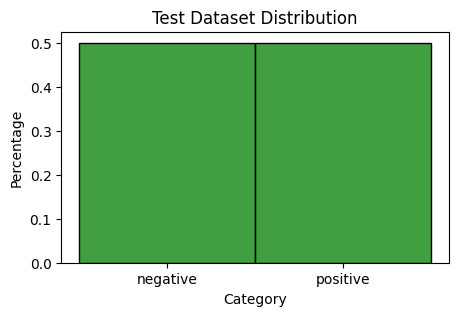

In [12]:
fig, ax = plt.subplots(figsize = (5, 3))
plt.title('Test Dataset Distribution')
sns.histplot(test_set.label, color='green', discrete=True, stat='probability')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

## Data Preprocessing

### Convert positive to 1, and negative to 0

In [13]:
# [Positive, Negative]
for i in range(len(train_set.label)):
  if train_set.label[i] == 'positive':
    train_set.label[i] = [1, 0]
  elif train_set.label[i] == 'negative':
    train_set.label[i] = [0, 1]

In [14]:
for i in range(len(test_set.label)):
  if test_set.label[i] == 'positive':
    test_set.label[i] = [1, 0]
  elif test_set.label[i] == 'negative':
    test_set.label[i] = [0, 1]

In [15]:
test_set

,text,label
0,"no movement , no yuks , not much of anything","[0, 1]"
1,"a gob of drivel so sickly sweet , even the eag...","[0, 1]"
2,"gangs of new york is an unapologetic mess , wh...","[0, 1]"
3,"we never really feel involved with the story ,...","[0, 1]"
4,this is one of polanski ' s best films,"[1, 0]"
...,...,...
1816,"an often deadly boring , strange reading of a ...","[0, 1]"
1817,the problem with concept films is that if the ...,"[0, 1]"
1818,"safe conduct , however ambitious and well inte...","[0, 1]"
1819,"a film made with as little wit , interest , an...","[0, 1]"


### Initial Values

In [16]:
MAX_LEN = 294
TRAIN_BATCH_SIZE = 12
VALID_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 2e-06
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Custom Dataset

In [17]:
class CustomDataset(Dataset):

  def __init__(self, dataframe, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.comment_text = dataframe.text
    self.targets = dataframe.label
    self.max_len = max_len

  def __len__(self):
    return len(self.comment_text)

  def __getitem__(self, index):
    comment_text = str(self.comment_text[index])
    comment_text = " ".join(comment_text.split())

    inputs = self.tokenizer.encode_plus(
        comment_text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        pad_to_max_length=True,
        return_token_type_ids=True
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(self.targets[index], dtype=torch.float)
    }

### Prepare Datasets for Processing

In [18]:
train_set = CustomDataset(train_set, tokenizer, MAX_LEN)
test_set = CustomDataset(test_set, tokenizer, MAX_LEN)

In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

## Implement BERT Transformer

In [25]:
class BERTClass(torch.nn.Module):
  def __init__(self):
    super(BERTClass, self).__init__()
    self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
    self.l2 = torch.nn.Dropout(0.3)
    self.l3 = torch.nn.Linear(768, 256)
    self.l4 = torch.nn.Linear(256, 2)
    self.relu = torch.nn.ReLU()

  def forward(self, ids, mask, token_type_ids):
    _, out1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
    out2 = self.l2(out1)
    out3 = self.l3(self.relu(out2))
    out4 = self.l4(out3)

    return out4

In [26]:
model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [27]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

### Train The Model

In [28]:
def train(epoch):
    model.train()
    for i,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if (i%100) == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [29]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.7192472815513611
Epoch: 0, Loss:  0.6804159879684448
Epoch: 0, Loss:  0.6637296080589294
Epoch: 0, Loss:  0.6386041641235352
Epoch: 0, Loss:  0.5108659267425537
Epoch: 0, Loss:  0.25760364532470703
Epoch: 0, Loss:  0.34553012251853943
Epoch: 1, Loss:  0.3566887378692627
Epoch: 1, Loss:  0.2896578907966614
Epoch: 1, Loss:  0.33174338936805725
Epoch: 1, Loss:  0.3534477949142456
Epoch: 1, Loss:  0.44724202156066895
Epoch: 1, Loss:  0.2360517829656601
Epoch: 1, Loss:  0.10666319727897644


## Validate The Performance Of The Model

In [30]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():

        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [31]:
outputs, targets = validation(epoch)

outputs = np.array(outputs) >= 0.5

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")


Accuracy Score = 0.8934651290499726
F1 Score (Micro) = 0.8958333333333333
F1 Score (Macro) = 0.8958152958152958
